In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import dataset
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn import metrics
import time

In [2]:
transform = transforms.Compose([
    # to-tensor
    transforms.ToTensor(),
    # resize
    transforms.Resize(128),
    # center-crop
    transforms.CenterCrop(128),
    # normalize
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
])

inception_preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
incidents = dataset.IncidentsDataset("Incidents-subset", transform=inception_preprocess)

In [4]:
train_indices, test_indices, _, _ = train_test_split(range(incidents.__len__()), incidents.targets, stratify=incidents.targets, test_size=.3)

In [5]:
len(train_indices), len(test_indices), incidents.__len__()

(4902, 2102, 7004)

In [6]:
batch_size = 32

train_split = Subset(incidents, train_indices)
test_split = Subset(incidents, test_indices)

train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_split, batch_size=batch_size)


In [7]:
dataloader = DataLoader(incidents, batch_size=batch_size, shuffle=True)

In [8]:
nSamples = incidents.__len__()
nClasses = len(incidents.labels)
imgShape = incidents.__getitem__(0)[0].shape

print("Number of samples: ", nSamples)
print("Number of classes: ", nClasses)
print("Shape of an image: ", imgShape)

Number of samples:  7004
Number of classes:  12
Shape of an image:  torch.Size([3, 299, 299])


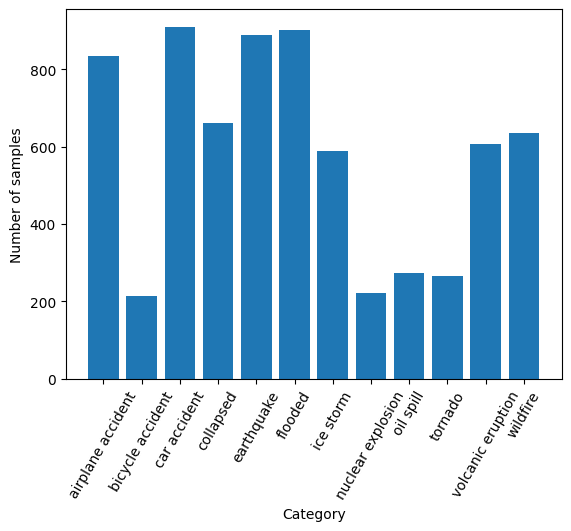

In [9]:
target, counts = np.unique(incidents.targets, return_counts=True)

_, ax = plt.subplots()

ax.bar(incidents.labels[target], counts) #, width=1, edgecolor="white", linewidth=.7)
plt.ylabel("Number of samples")
plt.xlabel("Category")
plt.xticks(rotation=60)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

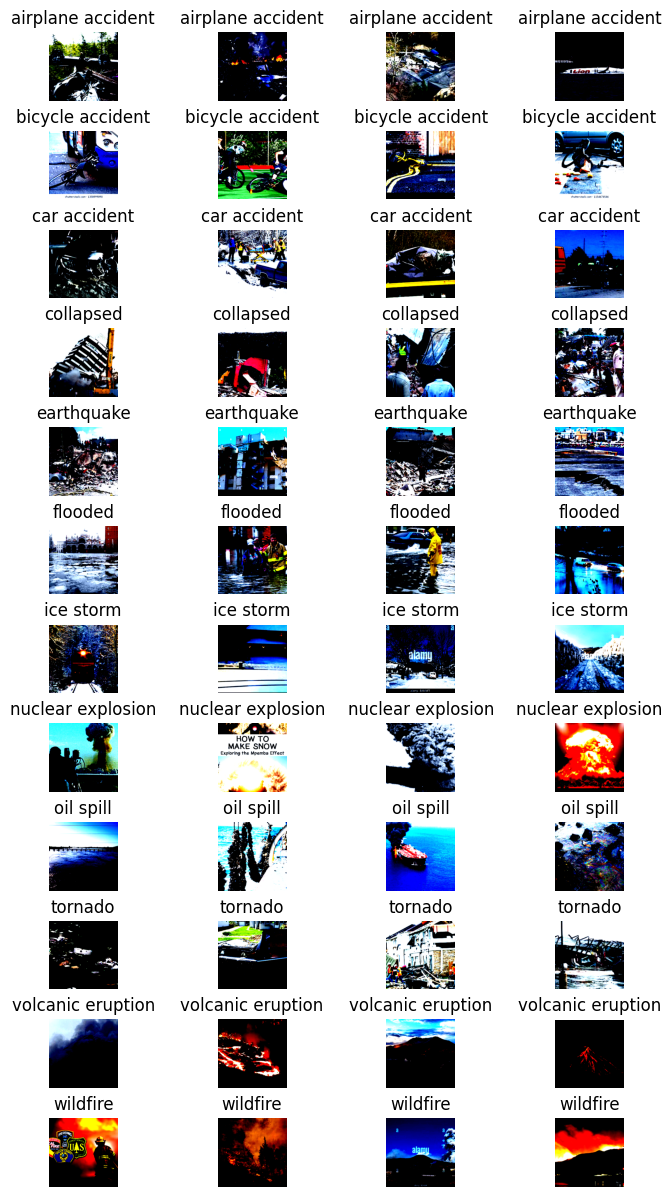

In [10]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111, nrows_ncols=(nClasses, 4), axes_pad=(1, .3))

images = []

for n in np.arange(nClasses):
    for i in range(4):
        img = incidents.get_item_with_target(n, i)
        idx = n*4+i
        grid[idx].imshow(img.permute(1, 2, 0))
        grid[idx].set_title(incidents.labels[n])
        grid[idx].axis('off')

In [11]:
from tqdm import tqdm

def train_model(model, num_epochs, train_loader, test_loader, criterion, optimizer):
    start = time.time()
    accuracy_history = {'train': [], 'test': []}
    loss_history = {'train': [], 'test': []}

    for epoch in range(num_epochs):
        print(f"Epoch: {epoch + 1}/{num_epochs}")

        running_loss_train, running_loss_test = 0.0, 0.0
        running_corrects_train, running_corrects_test = 0, 0

        print("Training...")
        model.train()  # Put the network in train mode
        for i, (x_batch, y_batch) in enumerate(tqdm(train_loader)):
            x_batch = x_batch.to(device)  # Move the data to the device that is used
            y_batch = y_batch.type(torch.LongTensor) # <---- Here (casting)
            y_batch = y_batch.to(device)

            # Compute prediction and loss
            # output = model(x_batch)

            # Required for inception model
            output, _ = model(x_batch)
            loss_train = criterion(output, y_batch)

            # Backpropagation
            optimizer.zero_grad()  # Set all currenly stored gradients to zero
            loss_train.backward()
            optimizer.step()

            # Compute relevant metrics
            _, preds = torch.max(output, dim=1)  # Get the labels with highest output probability

            running_loss_train += loss_train.item() * x_batch.size(0)
            running_corrects_train += torch.sum(preds == y_batch.data)

            elapsed = time.time() - start  # Keep track of how much time has elapsed

        print("Evaluating...")
        model.eval()  # Put the network in eval mode
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch = x_batch.to(device)  # Move the data to the device that is used
            y_batch = y_batch.type(torch.LongTensor) # <---- Here (casting)
            y_batch = y_batch.to(device)

            output = model(x_batch)
            loss_test = criterion(output, y_batch)
            _, preds = torch.max(output, dim=1)

            running_loss_test += loss_test.item() * x_batch.size(0)
            running_corrects_test += torch.sum(preds == y_batch.data)

        accuracy_history['train'].append(running_corrects_train/len(train_split))
        accuracy_history['test'].append(running_corrects_test/len(test_split))

        loss_history['train'].append(running_loss_train)
        loss_history['test'].append(running_loss_test)

        print(f'Accuracy on the train set: {running_corrects_train / len(train_split):.3f}. Loss: {running_loss_train:.3f}')
        print(f'Accuracy on the test set: {running_corrects_test / len(test_split):.3f}. Loss: {running_loss_test:.3f}')

    return model, accuracy_history, loss_history, time.time() - start

### Cross-Validation

In [12]:
import os

def save_curves(curves, model_name, mode, num_epochs, num_splits):
    train_curves, test_curves = np.zeros((num_splits, num_epochs)), np.zeros((num_splits, num_epochs))

    for i, curve in enumerate(curves):
        train, test = curve['train'], curve['test']
        if mode == "accuracy":
            train = [train[i].item() for i in range(train.__len__())]
            test = [test[i].item() for i in range(test.__len__())]

        for j, (train_value, test_value) in enumerate(zip(train, test)):
            train_curves[i, j] = train_value
            test_curves[i, j] = test_value

    dir_name = f"{model_name}"
    dir_exists = os.path.exists(dir_name)

    if not dir_exists:
        os.mkdir(dir_name)
    np.save(f"{dir_name}/{model_name}_train_{mode}.npy", train_curves)
    np.save(f"{dir_name}/{model_name}_test_{mode}.npy", test_curves)

In [13]:
from torchvision import models

model = models.inception_v3(weights=models.Inception_V3_Weights)

model
        # model.fc = torch.nn.Linear(2048, nClasses)

C:\Users\koend\anaconda3\envs\Data-Science\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [14]:
from torchvision import models

def get_model(name):
    if name == "inception":
        model = models.inception_v3(weights=models.Inception_V3_Weights)
        model.fc = torch.nn.Linear(2048, nClasses)
    elif name == "resnet":
        model = models.resnet50(weights=models.ResNet50_Weights)
        model.fc = torch.nn.Linear(2048, nClasses)
    elif name == "mobilenet":
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights)
        model.classifier[1] = torch.nn.Linear(1280, nClasses)
    else:
        model = None

    return model

In [15]:
def get_recall_f1_precision_accuracy_confusion_matrix(model, test_loader):
    predictions = []
    ground_truth = []
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            ground_truth.append(labels.numpy())
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions.append(predicted.cpu().numpy())

    ground_truth = np.concatenate(ground_truth)
    predictions = np.concatenate(predictions)
    accuracy = metrics.accuracy_score(ground_truth, predictions)
    f1 = metrics.f1_score(ground_truth, predictions, average='weighted')
    precision = metrics.precision_score(ground_truth, predictions, average='weighted')
    recall = metrics.recall_score(ground_truth, predictions, average='weighted')
    confusion_matrix = metrics.confusion_matrix(ground_truth, predictions)

    return recall, f1, precision, accuracy, confusion_matrix



In [16]:
from sklearn.model_selection import KFold
import json

num_splits = 5
kfold = KFold(n_splits=num_splits, shuffle=True)

num_epochs = 10

for model_name in ["inception"]:
    accuracy_curves = []
    loss_curves = []
    fold = 0
    recalls, f1s, precisions, accuracies, conf_matrices = [], [], [], [], []

    for train, test in kfold.split(incidents):
        # Creating model, the optimizers and criterion
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = get_model(model_name)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = torch.nn.CrossEntropyLoss()

        # Splitting data
        train_split = Subset(incidents, train)
        test_split = Subset(incidents, test)

        train_loader = DataLoader(train_split, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_split, batch_size=batch_size)

        # Training the model
        model, accuracy_history, loss_history, elapsed_time = train_model(model, num_epochs, train_loader, test_loader, criterion, optimizer)

        # Saving the model and its indices, so its train and test data can be reused
        torch.save(model.state_dict(), f"models/{model.__class__.__name__}_{fold}.pt")
        with open(f"models/{model.__class__.__name__}_{fold}_indices", 'w') as indices_file:
            indices_file.write(json.dumps({'train': train.tolist(), 'test': test.tolist()}))

        # Add all the metrics to lists, so they can be averaged and stored in files
        accuracy_curves.append(accuracy_history)
        loss_curves.append(loss_history)
        fold += 1

        recall, f1, precision, accuracy, conf_matrix = get_recall_f1_precision_accuracy_confusion_matrix(model, test_loader)
        recalls.append(recall)
        f1s.append(f1)
        precisions.append(precision)
        accuracies.append(accuracy)
        conf_matrices.append(conf_matrix)

    # Saving all the metrics to files
    average_metrics = {'recall': sum(recalls)/len(recalls), 'f1': sum(f1s)/len(f1s), 'precision': sum(precisions)/len(precisions), 'accuracy': sum(accuracies)/len(accuracies)}
    save_curves(accuracy_curves, model.__class__.__name__, "accuracy", num_epochs, num_splits)
    save_curves(loss_curves, model.__class__.__name__, "loss", num_epochs, num_splits)
    np.save(f"{model.__class__.__name__}/conf_matrix.npy", np.array(conf_matrices))

    with open(f"{model.__class__.__name__}/metrics.txt", 'w') as metrics_file:
        metrics_file.write(json.dumps(average_metrics))


Epoch: 1/10
Training...


100%|██████████| 176/176 [02:37<00:00,  1.12it/s]


Evaluating...
Accuracy on the train set: 0.549. Loss: 7763.931
Accuracy on the test set: 0.613. Loss: 1773.921
Epoch: 2/10
Training...


100%|██████████| 176/176 [32:47<00:00, 11.18s/it]


Evaluating...
Accuracy on the train set: 0.667. Loss: 5732.497
Accuracy on the test set: 0.594. Loss: 1910.459
Epoch: 3/10
Training...


100%|██████████| 176/176 [32:15<00:00, 11.00s/it]


Evaluating...
Accuracy on the train set: 0.721. Loss: 4757.282
Accuracy on the test set: 0.652. Loss: 1579.357
Epoch: 4/10
Training...


100%|██████████| 176/176 [33:10<00:00, 11.31s/it]


Evaluating...
Accuracy on the train set: 0.766. Loss: 3958.119
Accuracy on the test set: 0.567. Loss: 2177.834
Epoch: 5/10
Training...


100%|██████████| 176/176 [32:47<00:00, 11.18s/it]


Evaluating...
Accuracy on the train set: 0.786. Loss: 3642.243
Accuracy on the test set: 0.726. Loss: 1199.642
Epoch: 6/10
Training...


100%|██████████| 176/176 [34:03<00:00, 11.61s/it]


Evaluating...
Accuracy on the train set: 0.832. Loss: 2969.338
Accuracy on the test set: 0.694. Loss: 1473.677
Epoch: 7/10
Training...


100%|██████████| 176/176 [33:40<00:00, 11.48s/it]


Evaluating...
Accuracy on the train set: 0.853. Loss: 2525.590
Accuracy on the test set: 0.667. Loss: 1803.127
Epoch: 8/10
Training...


100%|██████████| 176/176 [33:06<00:00, 11.29s/it]


Evaluating...
Accuracy on the train set: 0.869. Loss: 2268.875
Accuracy on the test set: 0.620. Loss: 2350.203
Epoch: 9/10
Training...


100%|██████████| 176/176 [33:00<00:00, 11.25s/it]


Evaluating...
Accuracy on the train set: 0.897. Loss: 1784.142
Accuracy on the test set: 0.695. Loss: 1595.748
Epoch: 10/10
Training...


100%|██████████| 176/176 [32:37<00:00, 11.12s/it]


Evaluating...
Accuracy on the train set: 0.898. Loss: 1769.097
Accuracy on the test set: 0.695. Loss: 1588.507


C:\Users\koend\anaconda3\envs\Data-Science\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/10
Training...


100%|██████████| 176/176 [33:06<00:00, 11.29s/it]


Evaluating...
Accuracy on the train set: 0.550. Loss: 7771.589
Accuracy on the test set: 0.613. Loss: 1798.360
Epoch: 2/10
Training...


100%|██████████| 176/176 [33:19<00:00, 11.36s/it]


Evaluating...
Accuracy on the train set: 0.657. Loss: 5907.796
Accuracy on the test set: 0.655. Loss: 1546.752
Epoch: 3/10
Training...


100%|██████████| 176/176 [57:04<00:00, 19.46s/it]


Evaluating...
Accuracy on the train set: 0.722. Loss: 4721.297
Accuracy on the test set: 0.662. Loss: 1452.721
Epoch: 4/10
Training...


100%|██████████| 176/176 [2:22:03<00:00, 48.43s/it]  


Evaluating...
Accuracy on the train set: 0.765. Loss: 4101.407
Accuracy on the test set: 0.606. Loss: 2005.845
Epoch: 5/10
Training...


100%|██████████| 176/176 [2:26:11<00:00, 49.84s/it]  


Evaluating...
Accuracy on the train set: 0.802. Loss: 3488.140
Accuracy on the test set: 0.658. Loss: 1665.841
Epoch: 6/10
Training...


100%|██████████| 176/176 [2:24:41<00:00, 49.33s/it]  


Evaluating...
Accuracy on the train set: 0.833. Loss: 2860.345
Accuracy on the test set: 0.728. Loss: 1339.623
Epoch: 7/10
Training...


100%|██████████| 176/176 [2:32:45<00:00, 52.08s/it]  


Evaluating...
Accuracy on the train set: 0.845. Loss: 2600.000
Accuracy on the test set: 0.672. Loss: 1799.352
Epoch: 8/10
Training...


100%|██████████| 176/176 [2:36:42<00:00, 53.42s/it]  


Evaluating...
Accuracy on the train set: 0.863. Loss: 2479.606
Accuracy on the test set: 0.684. Loss: 1561.725
Epoch: 9/10
Training...


100%|██████████| 176/176 [2:37:19<00:00, 53.63s/it]  


Evaluating...
Accuracy on the train set: 0.874. Loss: 2154.233
Accuracy on the test set: 0.668. Loss: 1703.394
Epoch: 10/10
Training...


100%|██████████| 176/176 [2:27:12<00:00, 50.19s/it]  


Evaluating...
Accuracy on the train set: 0.896. Loss: 1789.691
Accuracy on the test set: 0.683. Loss: 1588.542


C:\Users\koend\anaconda3\envs\Data-Science\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/10
Training...


100%|██████████| 176/176 [1:29:24<00:00, 30.48s/it] 


Evaluating...
Accuracy on the train set: 0.541. Loss: 7963.982
Accuracy on the test set: 0.537. Loss: 2077.133
Epoch: 2/10
Training...


100%|██████████| 176/176 [03:20<00:00,  1.14s/it]


Evaluating...
Accuracy on the train set: 0.655. Loss: 5912.650
Accuracy on the test set: 0.613. Loss: 1597.181
Epoch: 3/10
Training...


100%|██████████| 176/176 [03:22<00:00,  1.15s/it]


Evaluating...
Accuracy on the train set: 0.711. Loss: 4848.030
Accuracy on the test set: 0.589. Loss: 1906.288
Epoch: 4/10
Training...


100%|██████████| 176/176 [03:23<00:00,  1.15s/it]


Evaluating...
Accuracy on the train set: 0.745. Loss: 4434.751
Accuracy on the test set: 0.675. Loss: 1446.405
Epoch: 5/10
Training...


100%|██████████| 176/176 [03:21<00:00,  1.14s/it]


Evaluating...
Accuracy on the train set: 0.798. Loss: 3510.788
Accuracy on the test set: 0.677. Loss: 1544.232
Epoch: 6/10
Training...


100%|██████████| 176/176 [03:20<00:00,  1.14s/it]


Evaluating...
Accuracy on the train set: 0.795. Loss: 3464.170
Accuracy on the test set: 0.632. Loss: 1551.298
Epoch: 7/10
Training...


100%|██████████| 176/176 [03:21<00:00,  1.14s/it]


Evaluating...
Accuracy on the train set: 0.844. Loss: 2699.524
Accuracy on the test set: 0.627. Loss: 1856.487
Epoch: 8/10
Training...


100%|██████████| 176/176 [03:21<00:00,  1.14s/it]


Evaluating...
Accuracy on the train set: 0.868. Loss: 2236.000
Accuracy on the test set: 0.712. Loss: 1342.429
Epoch: 9/10
Training...


100%|██████████| 176/176 [03:21<00:00,  1.15s/it]


Evaluating...
Accuracy on the train set: 0.888. Loss: 1946.624
Accuracy on the test set: 0.685. Loss: 1702.644
Epoch: 10/10
Training...


100%|██████████| 176/176 [03:21<00:00,  1.15s/it]


Evaluating...
Accuracy on the train set: 0.894. Loss: 1791.325
Accuracy on the test set: 0.682. Loss: 1683.357


C:\Users\koend\anaconda3\envs\Data-Science\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/10
Training...


100%|██████████| 176/176 [03:20<00:00,  1.14s/it]


Evaluating...
Accuracy on the train set: 0.547. Loss: 7831.113
Accuracy on the test set: 0.565. Loss: 1934.667
Epoch: 2/10
Training...


100%|██████████| 176/176 [03:20<00:00,  1.14s/it]


Evaluating...
Accuracy on the train set: 0.668. Loss: 5696.395
Accuracy on the test set: 0.438. Loss: 2680.839
Epoch: 3/10
Training...


100%|██████████| 176/176 [03:20<00:00,  1.14s/it]


Evaluating...
Accuracy on the train set: 0.698. Loss: 5141.226
Accuracy on the test set: 0.671. Loss: 1533.318
Epoch: 4/10
Training...


100%|██████████| 176/176 [03:20<00:00,  1.14s/it]


Evaluating...
Accuracy on the train set: 0.756. Loss: 4220.585
Accuracy on the test set: 0.622. Loss: 1638.601
Epoch: 5/10
Training...


100%|██████████| 176/176 [03:21<00:00,  1.14s/it]


Evaluating...
Accuracy on the train set: 0.809. Loss: 3391.184
Accuracy on the test set: 0.667. Loss: 1481.066
Epoch: 6/10
Training...


100%|██████████| 176/176 [03:17<00:00,  1.12s/it]


Evaluating...
Accuracy on the train set: 0.832. Loss: 2897.850
Accuracy on the test set: 0.672. Loss: 1525.770
Epoch: 7/10
Training...


100%|██████████| 176/176 [03:18<00:00,  1.13s/it]


Evaluating...
Accuracy on the train set: 0.850. Loss: 2615.532
Accuracy on the test set: 0.686. Loss: 1508.338
Epoch: 8/10
Training...


100%|██████████| 176/176 [03:16<00:00,  1.12s/it]


Evaluating...
Accuracy on the train set: 0.863. Loss: 2306.594
Accuracy on the test set: 0.693. Loss: 1503.592
Epoch: 9/10
Training...


100%|██████████| 176/176 [03:21<00:00,  1.14s/it]


Evaluating...
Accuracy on the train set: 0.865. Loss: 2375.182
Accuracy on the test set: 0.729. Loss: 1377.572
Epoch: 10/10
Training...


100%|██████████| 176/176 [03:22<00:00,  1.15s/it]


Evaluating...
Accuracy on the train set: 0.891. Loss: 1859.108
Accuracy on the test set: 0.674. Loss: 1836.687


C:\Users\koend\anaconda3\envs\Data-Science\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/10
Training...


100%|██████████| 176/176 [03:22<00:00,  1.15s/it]


Evaluating...
Accuracy on the train set: 0.541. Loss: 7907.625
Accuracy on the test set: 0.597. Loss: 1735.339
Epoch: 2/10
Training...


100%|██████████| 176/176 [03:23<00:00,  1.15s/it]


Evaluating...
Accuracy on the train set: 0.661. Loss: 5902.184
Accuracy on the test set: 0.619. Loss: 1674.553
Epoch: 3/10
Training...


100%|██████████| 176/176 [03:22<00:00,  1.15s/it]


Evaluating...
Accuracy on the train set: 0.724. Loss: 4750.216
Accuracy on the test set: 0.626. Loss: 1708.085
Epoch: 4/10
Training...


100%|██████████| 176/176 [03:21<00:00,  1.15s/it]


Evaluating...
Accuracy on the train set: 0.773. Loss: 3968.703
Accuracy on the test set: 0.664. Loss: 1518.356
Epoch: 5/10
Training...


100%|██████████| 176/176 [03:21<00:00,  1.14s/it]


Evaluating...
Accuracy on the train set: 0.792. Loss: 3527.993
Accuracy on the test set: 0.686. Loss: 1464.108
Epoch: 6/10
Training...


100%|██████████| 176/176 [03:22<00:00,  1.15s/it]


Evaluating...
Accuracy on the train set: 0.830. Loss: 2943.917
Accuracy on the test set: 0.656. Loss: 1680.526
Epoch: 7/10
Training...


100%|██████████| 176/176 [03:22<00:00,  1.15s/it]


Evaluating...
Accuracy on the train set: 0.833. Loss: 2808.946
Accuracy on the test set: 0.632. Loss: 1925.885
Epoch: 8/10
Training...


100%|██████████| 176/176 [03:21<00:00,  1.15s/it]


Evaluating...
Accuracy on the train set: 0.872. Loss: 2218.836
Accuracy on the test set: 0.689. Loss: 1721.818
Epoch: 9/10
Training...


100%|██████████| 176/176 [03:20<00:00,  1.14s/it]


Evaluating...
Accuracy on the train set: 0.896. Loss: 1803.709
Accuracy on the test set: 0.664. Loss: 1708.742
Epoch: 10/10
Training...


100%|██████████| 176/176 [03:22<00:00,  1.15s/it]


Evaluating...
Accuracy on the train set: 0.878. Loss: 2079.886
Accuracy on the test set: 0.711. Loss: 1421.301


In [17]:
# import os
#
# def save_curves(curves, model_name, pretrained, mode, num_epochs, num_splits):
#     train_curves, test_curves = np.zeros((num_splits, num_epochs)), np.zeros((num_splits, num_epochs))
#
#     for i, curve in enumerate(curves):
#         train, test = curve['train'], curve['test']
#         if mode == "accuracy":
#             train = [train[i].item() for i in range(train.__len__())]
#             test = [test[i].item() for i in range(test.__len__())]
#
#         for j, (train_value, test_value) in enumerate(zip(train, test)):
#             train_curves[i, j] = train_value
#             test_curves[i, j] = test_value
#
#     dir_name = f"{model_name}_{int(pretrained)}"
#     dir_exists = os.path.exists(dir_name)
#
#     if not dir_exists:
#         os.mkdir(dir_name)
#     np.save(f"{dir_name}/{model_name}_{int(pretrained)}_train_{mode}.npy", train_curves)
#     np.save(f"{dir_name}/{model_name}_{int(pretrained)}_test_{mode}.npy", test_curves)


# save_curves(accuracy_curves, model.__class__.__name__, False, "accuracy", num_epochs, num_splits)
# save_curves(loss_curves, model.__class__.__name__, False, "loss", num_epochs, num_splits)

In [18]:
f = open("ResNet_0/dict.txt","w")
# f.close()

FileNotFoundError: [Errno 2] No such file or directory: 'ResNet_0/dict.txt'

In [ ]:
# metrics_file.close()

In [ ]:
x = np.load("ResNet/conf_matrix.npy")